In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import os,time,datetime,sys

### 1D Inviscid Euler Equation

$$

\begin{aligned}
&\partial_t U + \nabla\cdot f(U)=0, \quad  x\in\Omega\subset\mathbb{R},t\in(0,T] \\

& U = \begin{bmatrix}
\rho \\
\rho u \\
\rho E
\end{bmatrix}
\quad
f(U) = \begin{bmatrix}
\rho u\\
\rho u^2 +p \\
u(\rho E+p)
\end{bmatrix}, \quad p=(\gamma-1)(\rho E-\frac{1}{2}\rho||u||^2), \quad \gamma=1.4  \\
\\
&\text{IC}\\
& \qquad \text{initial shock is given at } x=0.5\\
& \qquad (\rho_L,u_L,p_L)=(1.4,0.1,1.0) \qquad (\rho_R,u_R,p_R)=(1.0,0.1,1.0) \\
&\text{BC} \quad x\in[0,1]\\
&\qquad \text{Dirichlet boundary}\\

&\text{exact solution} \\
&\qquad \rho(x,t)=\left\{
    \begin{aligned}
        1.4 \quad x<0.5+0.1t \\
        1.0 \quad x>0.5+0.1t
    \end{aligned}
\right.

\quad u(x,t)=0.1 \quad p(x,t)=1.0

\end{aligned}

$$


### PINNs Model

In [38]:
class PINN(tf.keras.Model):
    def __init__(
            self,
            t,x,u,t_r,x_r,lb,ub,
            in_dim,out_dim,width,depth,
            activ="tanh",w_init="glorot_normal",b_init="zeros",
            lr=1e-3,opt="Adam",
            info_seed=1234):
        super().__init__()
        # information
        self.info_seed = info_seed
        # initial the data
        self.data_type = tf.float32
        self.x = tf.convert_to_tensor(x,dtype=self.data_type)
        self.t = tf.convert_to_tensor(t,dtype=self.data_type)
        self.u = tf.convert_to_tensor(u,dtype=self.data_type)
        # pde loss train point = inner + outer(initial+boundary)
        t_r = tf.concat([t,t_r],axis=0)
        x_r = tf.concat([x,x_r],axis=0)
        self.x_r = tf.convert_to_tensor(x_r,dtype=self.data_type)
        self.t_r = tf.convert_to_tensor(t_r,dtype=self.data_type)
        self.lb = tf.convert_to_tensor(lb,dtype=self.data_type)
        self.ub = tf.convert_to_tensor(ub,dtype=self.data_type)
        # neuron network configuration
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.width = width
        self.depth = depth
        self.activ = activ
        self.w_init = w_init
        self.b_init = b_init
        self.lr = lr
        self.opt = opt
        
        # call
        self.dnn = self.dnn_init()
        self.params = self.dnn.trainable_variables
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

        # track loss
        self.ep_log = []
        self.loss_log = []

        print(">>>>> start time:", datetime.datetime.now())
        print(">>>>> configuration;")
        print("         dtype        :", self.data_type)
        print("         activ func   :", self.activ)
        print("         weight init  :", self.w_init)
        print("         learning rate:", self.lr)
        print("         optimizer    :", self.opt)
        print("         summary      :", self.dnn.summary())
    
    def dnn_init(self):
        net = tf.keras.Sequential()
        net.add(tf.keras.layers.InputLayer(self.in_dim))
        # net.add(tf.keras.layers.Lambda(lambda x: 2. * (x - self.lb) / (self.ub - self.lb) - 1.))
        for l in range(self.depth - 1):
            net.add(tf.keras.layers.Dense(units=self.width, activation = self.activ,kernel_initializer = self.w_init, bias_initializer = self.b_init))
        net.add(tf.keras.layers.Dense(self.out_dim))
        return net

    
    def loss_pde(self):
        with tf.GradientTape(persistent=True) as tp:
            tp.watch(self.t_r)
            tp.watch(self.x_r)
            u = self.dnn(tf.concat([self.t_r,self.x_r],1))
            rho = u[:,0][:,None]
            v = u[:,1][:,None]
            p = u[:,2][:,None]
        rho_t = tp.gradient(rho,self.t_r)
        v_t = tp.gradient(v,self.t_r)
        p_t = tp.gradient(p,self.t_r)
        rho_x = tp.gradient(rho,self.x_r)
        v_x = tp.gradient(v,self.x_r)
        p_x = tp.gradient(p,self.x_r)
        del tp
        equ_1 = rho_t + rho_x*v + rho*v_x
        equ_2 = (rho_t*v + rho*v_t) + (rho*(2*v*v_x) +(v**2)*rho_x + p_x)
        equ_3 = (5/2*p_t+1/2*rho_t*v*v+rho*v*v_t)+(v_x*(7/2*p+1/2*rho*v*v)+v*(7/2*p_x+1/2*rho_x*v*v+rho*v*v_x))
        r = tf.reduce_mean(tf.square(equ_1)+tf.square(equ_2)+tf.square(equ_3))
        return r

    def loss_icbc(self):
        u_nn = self.dnn(tf.concat([self.t,self.x],1))
        return tf.reduce_mean(tf.square(self.u-u_nn))*3

    @tf.function
    def grad_desc(self):
        with tf.GradientTape() as tp:
            loss = self.loss_pde() + self.loss_icbc()
        grad = tp.gradient(loss,self.params)
        del tp
        self.optimizer.apply_gradients(zip(grad,self.params))
        return loss
    
    def train(self,epoch,tol,info_freq):
        print(">>>>> training setting;")
        print("         # of epoch     :", epoch)
        print("         convergence tol:", tol)
        t0 = time.time()
        for ep in range(epoch+1):
            ep_loss = self.grad_desc()
            if ep % info_freq ==0:
                elps = time.time() -t0
                self.ep_log.append(ep)
                self.loss_log.append(ep_loss)
                print("ep: %d, loss: %.3e, elps: %.3f" % (ep, ep_loss, elps))
                t0 = time.time()
            if ep_loss < tol:
                print(">>>>> end time:", datetime.datetime.now())
                break
        print(">>>>> end time:", datetime.datetime.now())

    def predict(self,t,x):
        return self.dnn(tf.concat([t,x],1))

### Structure of the Costum PINNs

In [39]:
in_dim = 2
out_dim = 3
width = 20
depth = 7

epoch = 12000
tol = 1e-8

N_0 = 60
N_b = 60
N_r = 1000

w_init = "glorot_normal"
b_init = "zeros"
act = "tanh"

lr = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 8e-3,
    decay_steps = epoch,
    alpha = 1e-2
)


opt = "Adam"
info_freq = 500
info_seed = 1234


print("python    :", sys.version)
print("tensorflow:", tf.__version__)
print("rand seed :", info_seed)
os.environ["PYTHONHASHSEED"] = str(info_seed)

python    : 3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
tensorflow: 2.9.1
rand seed : 1234


### 1D Inviscid Euler Equation

$$

\begin{aligned}
&\partial_t U + \nabla\cdot f(U)=0, \quad  x\in\Omega\subset\mathbb{R},t\in(0,T] \\

& U = \begin{bmatrix}
\rho \\
\rho u
\end{bmatrix}
\quad
f(U) = \begin{bmatrix}
\rho u\\
\rho u^2 +p 
\end{bmatrix} \\
\\
&\text{BC/IC } \quad [-1,1]\times[0,1]\\
&\qquad U(-1,t) = U(1,t), \quad \nabla U(-1,t)=\nabla U(1,t)\\
&\qquad U_0 = (\rho_0,u_0,p_0) = (1+0.2\sin(\pi x),1,1)\\

&\text{exact solution} \\
&\qquad U = (\rho,u,p) = (1+0.2\sin(\pi(x-t)),1,1)\\

\end{aligned}

$$


In [40]:
tmin, tmax = 0., 2.
xmin, xmax = 0., 1.
lb = tf.constant([tmin, xmin], dtype = tf.float32)
ub = tf.constant([tmax, xmax], dtype = tf.float32)

t_0 = tf.ones((N_0, 1), dtype = tf.float32) * lb[0]
x_0 = tf.random.uniform((N_0, 1), lb[1], ub[1], dtype = tf.float32)
u_0 = tf.convert_to_tensor([[1.4 if x<0.5 else 1.0 ,0.1,1.0] for x in x_0.numpy()],dtype=tf.float32)

t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype = tf.float32)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b, 1), .5, dtype = tf.float32)
u_b = tf.convert_to_tensor([[1.4 if x_b[i]<0.5+0.1*t_b[i] else 1.0 ,0.1 ,1.0] for i in range(len(x_b.numpy()))],dtype=tf.float32)

t = tf.concat([t_0,t_b],axis=0)
x = tf.concat([x_0,x_b],axis=0)
u = tf.concat([u_0,u_b],axis=0)

t_r_rand = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype = tf.float32)
x_r_rand = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype = tf.float32)

t_r_clus = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype = tf.float32)
noise = 0.1
a = 0.1
b = 0.5
cc = np.random.choice(range(t_r_clus.shape[0]),size=int(N_r*0.6), replace=False)
x_r_clus =tf.convert_to_tensor([ [a*(1+np.random.randn()*noise)*t_r_clus[i].numpy()[0]+b*(1+np.random.randn()*noise)] if (i in cc) else [np.random.random()] for i in range(len(t_r_clus))],dtype=tf.float32)

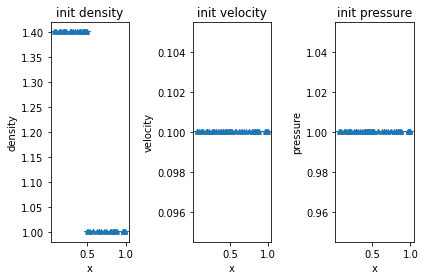

In [41]:
fig,ax = plt.subplots(1,3)
ax[0].plot(x_0,u_0[:,0],"*")
ax[0].set_title("init density")
ax[0].set_xlabel("x")
ax[0].set_ylabel("density")

ax[1].plot(x_0,u_0[:,1],"*")
ax[1].set_title("init velocity")
ax[1].set_xlabel("x")
ax[1].set_ylabel("velocity")

ax[2].plot(x_0,u_0[:,2],"*")
ax[2].set_title("init pressure")
ax[2].set_xlabel("x")
ax[2].set_ylabel("pressure")

fig.tight_layout()

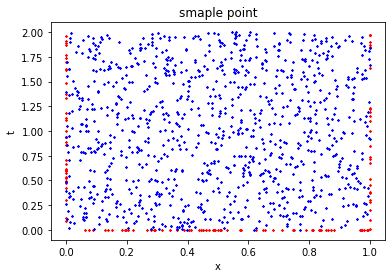

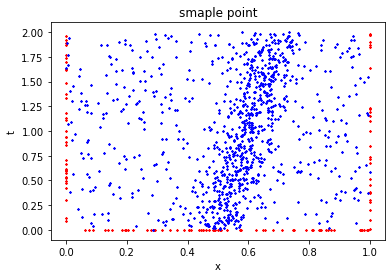

In [42]:
fig1,ax1 = plt.subplots(1)
ax1.set_ylabel("t")
ax1.set_xlabel("x")
ax1.set_title("smaple point")
ax1.plot(x_0,t_0,"*",color="r",markersize=2)
ax1.plot(x_b,t_b,"*",color="r",markersize=2)
ax1.plot(x_r_rand,t_r_rand,"*",color="b",markersize=2)

fig2,ax2 = plt.subplots(1)
ax2.set_ylabel("t")
ax2.set_xlabel("x")
ax2.set_title("smaple point")
ax2.plot(x_0,t_0,"*",color="r",markersize=2)
ax2.plot(x_b,t_b,"*",color="r",markersize=2)
ax2.plot(x_r_clus,t_r_clus,"*",color="b",markersize=2)

#plt.savefig("uniform sample point")
#plt.savefig("clustered sample point")

In [43]:
pinn_clus = PINN(
            t,x,u,
            t_r_clus,x_r_clus,
            lb,ub,
            in_dim,out_dim,width,depth,
            act,w_init,b_init,
            lr,opt,info_seed)

>>>>> start time: 2022-07-20 17:24:27.422082
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : tanh
         weight init  : glorot_normal
         learning rate: <keras.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x0000027D270B3430>
         optimizer    : Adam
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 20)                60        
                                                                 
 dense_29 (Dense)            (None, 20)                420       
                                                                 
 dense_30 (Dense)            (None, 20)                420       
                                                                 
 dense_31 (Dense)            (None, 20)                420       
                                                              

In [44]:
pinn_clus.train(epoch,tol,info_freq)

>>>>> training setting;
         # of epoch     : 12000
         convergence tol: 1e-08
ep: 0, loss: 3.595e+00, elps: 1.475
ep: 500, loss: 9.037e-03, elps: 1.697
ep: 1000, loss: 5.986e-03, elps: 1.693
ep: 1500, loss: 3.583e-03, elps: 1.685
ep: 2000, loss: 2.524e-03, elps: 1.698
ep: 2500, loss: 1.836e-03, elps: 1.695
ep: 3000, loss: 1.601e-03, elps: 1.699
ep: 3500, loss: 2.474e-03, elps: 1.693
ep: 4000, loss: 8.986e-04, elps: 1.692
ep: 4500, loss: 1.277e-03, elps: 1.701
ep: 5000, loss: 1.771e-03, elps: 1.680
ep: 5500, loss: 2.664e-04, elps: 1.816
ep: 6000, loss: 2.719e-04, elps: 2.070
ep: 6500, loss: 2.362e-04, elps: 2.076
ep: 7000, loss: 6.980e-05, elps: 2.069
ep: 7500, loss: 4.263e-05, elps: 2.058
ep: 8000, loss: 4.512e-05, elps: 2.050
ep: 8500, loss: 1.982e-05, elps: 2.061
ep: 9000, loss: 1.431e-05, elps: 2.052
ep: 9500, loss: 1.179e-05, elps: 2.070
ep: 10000, loss: 1.021e-05, elps: 2.073
ep: 10500, loss: 9.210e-06, elps: 2.076
ep: 11000, loss: 8.588e-06, elps: 2.062
ep: 11500, loss:

In [45]:
pinn_rand = PINN(
          t,x,u,
          t_r_rand,x_r_rand,
          lb,ub,
          in_dim,out_dim,width,depth,
          act,w_init,b_init,
          lr,opt,info_seed)

>>>>> start time: 2022-07-20 17:25:14.709328
>>>>> configuration;
         dtype        : <dtype: 'float32'>
         activ func   : tanh
         weight init  : glorot_normal
         learning rate: <keras.optimizers.schedules.learning_rate_schedule.CosineDecay object at 0x0000027D270B3430>
         optimizer    : Adam
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 20)                60        
                                                                 
 dense_36 (Dense)            (None, 20)                420       
                                                                 
 dense_37 (Dense)            (None, 20)                420       
                                                                 
 dense_38 (Dense)            (None, 20)                420       
                                                              

In [46]:
pinn_rand.train(epoch,tol,info_freq)

>>>>> training setting;
         # of epoch     : 12000
         convergence tol: 1e-08
ep: 0, loss: 3.298e+00, elps: 1.480
ep: 500, loss: 6.822e-03, elps: 2.123
ep: 1000, loss: 5.660e-03, elps: 2.250
ep: 1500, loss: 2.533e-03, elps: 2.208
ep: 2000, loss: 1.222e-03, elps: 2.214
ep: 2500, loss: 6.033e-04, elps: 2.232
ep: 3000, loss: 2.464e-04, elps: 2.210
ep: 3500, loss: 1.313e-04, elps: 2.292
ep: 4000, loss: 1.106e-04, elps: 2.215
ep: 4500, loss: 7.205e-05, elps: 2.208
ep: 5000, loss: 3.417e-05, elps: 2.204
ep: 5500, loss: 4.218e-05, elps: 2.210
ep: 6000, loss: 1.265e-04, elps: 2.249
ep: 6500, loss: 1.303e-05, elps: 2.249
ep: 7000, loss: 2.000e-05, elps: 2.256
ep: 7500, loss: 1.627e-05, elps: 2.240
ep: 8000, loss: 6.301e-06, elps: 2.246
ep: 8500, loss: 5.251e-06, elps: 2.241
ep: 9000, loss: 3.164e-06, elps: 2.203
ep: 9500, loss: 2.651e-06, elps: 2.159
ep: 10000, loss: 2.297e-06, elps: 2.454
ep: 10500, loss: 2.055e-06, elps: 2.562
ep: 11000, loss: 1.897e-06, elps: 2.217
ep: 11500, loss:

### Visualization

> LOSS

Text(0.5, 1.0, 'train loss(part)')

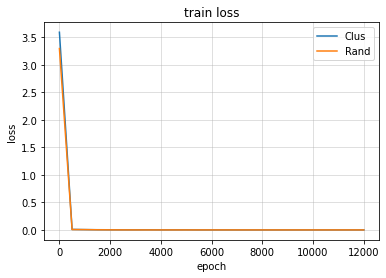

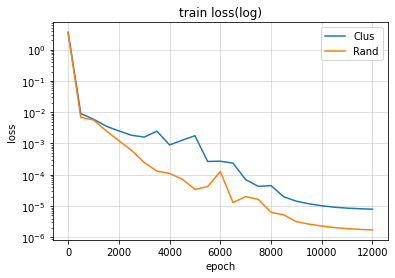

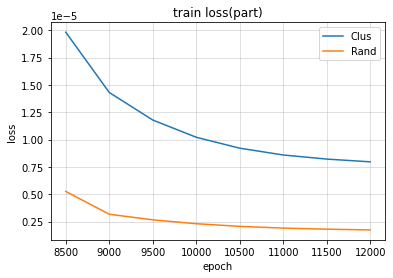

In [47]:
fig1,ax1 = plt.subplots(1)
ax1.plot(pinn_clus.ep_log,pinn_clus.loss_log,label="Clus")
ax1.plot(pinn_rand.ep_log,pinn_rand.loss_log,label="Rand")
ax1.grid(alpha=0.5)
ax1.set_ylabel("loss")
ax1.set_xlabel("epoch")
ax1.set_title("train loss")
ax1.legend(loc='upper right')

fig2,ax2 = plt.subplots(1)
ax2.plot(pinn_clus.ep_log,pinn_clus.loss_log,label="Clus")
ax2.plot(pinn_rand.ep_log,pinn_rand.loss_log,label="Rand")
ax2.grid(alpha=0.5)
ax2.set_ylabel("loss")
ax2.set_xlabel("epoch")
ax2.set_yscale("log")
ax2.set_title("train loss(log)")
ax2.legend(loc='upper right')

fig3,ax3 = plt.subplots(1)
strt = int(len(pinn_clus.ep_log)*0.7)
ax3.plot(pinn_clus.ep_log[strt:],pinn_clus.loss_log[strt:],label="Clus")
ax3.plot(pinn_rand.ep_log[strt:],pinn_rand.loss_log[strt:],label="Rand")
ax3.grid(alpha=0.5)
ax3.set_xlabel("epoch")
ax3.set_ylabel("loss")
ax3.legend(loc='upper right')
ax3.set_title("train loss(part)")

# savepath="./pics"
# title = "loss"
# if not os.path.exists(savepath):
#    os.makedirs(savepath)
# fig1.savefig(savepath+"/"+title)
# fig2.savefig(savepath+"/"+title+"(log)")
# fig3.savefig(savepath+"/"+title+"(part")


### Solution in domain

In [48]:
t = np.linspace(tmin,tmax,1001)
x = np.linspace(xmin,xmax,1001)
t,x = np.meshgrid(t,x)
u_clus = pinn_clus.predict(t.flatten()[:,None],x.flatten()[:,None])
u_rand = pinn_rand.predict(t.flatten()[:,None],x.flatten()[:,None])
density_clus = u_clus[:,0].numpy().reshape(-1,len(t[0])).T
velocity_clus = u_clus[:,1].numpy().reshape(-1,len(t[0])).T
pressure_clus = u_clus[:,2].numpy().reshape(-1,len(t[0])).T

density_rand = u_rand[:,0].numpy().reshape(-1,len(t[0])).T
velocity_rand = u_rand[:,1].numpy().reshape(-1,len(t[0])).T
pressure_rand = u_rand[:,2].numpy().reshape(-1,len(t[0])).T


### Solution

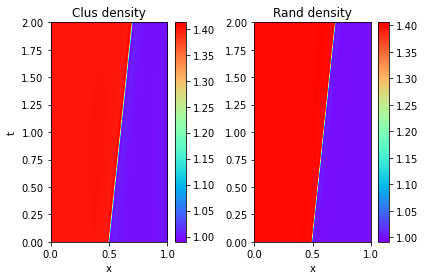

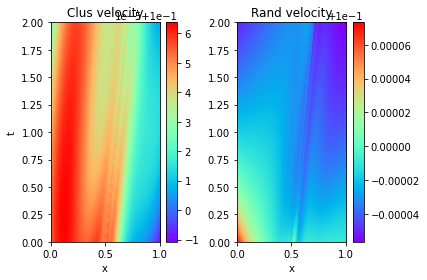

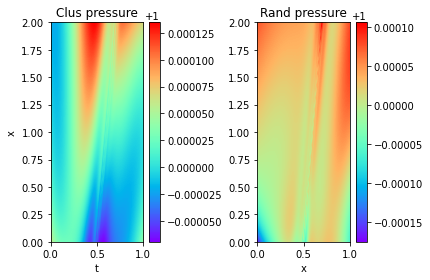

In [49]:
fig1,ax1 =plt.subplots(1,2)
img1 = ax1[0].imshow(density_clus,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
img2 = ax1[1].imshow(density_rand,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
plt.colorbar(img1,ax=ax1[0])
plt.colorbar(img2,ax=ax1[1])
ax1[0].set_title("Clus density")
ax1[0].set_xlabel('x') 
ax1[0].set_ylabel('t')
ax1[1].set_title("Rand density")
ax1[1].set_xlabel('x') 
fig1.tight_layout()

fig2,ax2 =plt.subplots(1,2)
img1 = ax2[0].imshow(velocity_clus,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
img2 = ax2[1].imshow(velocity_rand,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
plt.colorbar(img1,ax=ax2[0])
plt.colorbar(img2,ax=ax2[1])
ax2[0].set_title("Clus velocity")
ax2[0].set_xlabel('x')
ax2[0].set_ylabel('t')
ax2[1].set_title("Rand velocity")
ax2[1].set_xlabel('x')
fig2.tight_layout()

fig3,ax3 =plt.subplots(1,2)
img1 = ax3[0].imshow(pressure_clus,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
img2 = ax3[1].imshow(pressure_rand,interpolation='nearest',cmap='rainbow',extent=[xmin,xmax,tmin,tmax],origin="lower",aspect="auto")
plt.colorbar(img1,ax=ax3[0])
plt.colorbar(img2,ax=ax3[1])
ax3[0].set_title("Clus pressure")
ax3[0].set_xlabel('t') 
ax3[0].set_ylabel('x')
ax3[1].set_title("Rand pressure")
ax3[1].set_xlabel('x')
fig3.tight_layout()

# if not os.path.exists(savepath):
#     os.makedirs(savepath)
# fig1.savefig(savepath+"/density")
# fig2.savefig(savepath+"/velocity")
# fig3.savefig(savepath+"/pressure")

### Solution at tmax

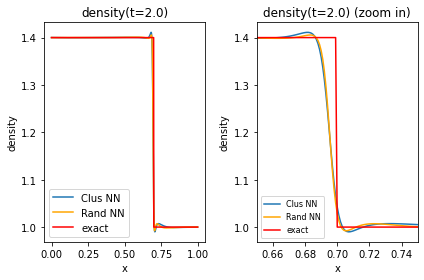

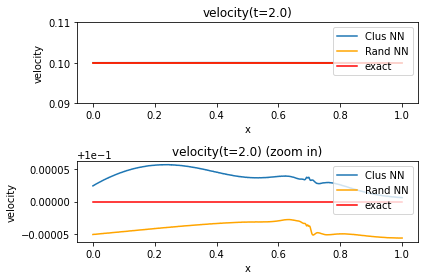

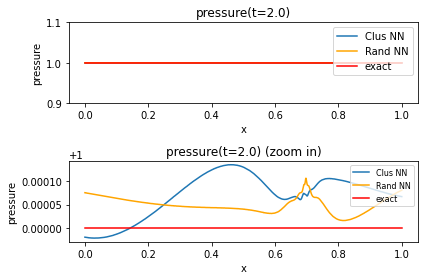

In [72]:
fig1,ax1 = plt.subplots(1,2)
ax1[0].set_title(f"density(t={tmax})")
ax1[0].set_xlabel('x')
ax1[0].set_ylabel('density')
ax1[0].plot(x[:,0],density_clus[-1],label="Clus NN")
ax1[0].plot(x[:,0],density_rand[-1],color="orange",label="Rand NN",markersize=3)
yy = np.array([1.4 if tmp<0.5+0.1*tmax else 1.0 for tmp in x[:,0]])
ax1[0].plot(x[:,0],yy,color="r",label='exact')
ax1[0].legend(loc="lower left")
ax1[1].set_title(f"density(t={tmax}) (zoom in)")
ax1[1].set_xlabel('x')
ax1[1].set_ylabel('density')
ax1[1].plot(x[:,0],density_clus[-1],label="Clus NN")
ax1[1].plot(x[:,0],density_rand[-1],color="orange",label="Rand NN",markersize=3)
yy = np.array([1.4 if tmp<0.5+0.1*tmax else 1.0 for tmp in x[:,0]])
ax1[1].plot(x[:,0],yy,color="r",label='exact')
ax1[1].legend(loc="lower left",fontsize=8)
ax1[1].set_xlim(0.65,0.75)
fig1.tight_layout()

fig2,ax2 = plt.subplots(2)
ax2[0].set_title(f"velocity(t={tmax})")
ax2[0].set_xlabel('x')
ax2[0].set_ylabel('velocity')
ax2[0].plot(x[:,0],velocity_clus[-1],label="Clus NN")
ax2[0].plot(x[:,0],velocity_rand[-1],color="orange",label="Rand NN",markersize=3)
ax2[0].plot(x[:,0],np.ones(len(x[:,0]))*0.1,color="r",label="exact")
ax2[0].legend(loc="upper right")
ax2[0].set_ylim(0.09,0.11)
ax2[1].set_title(f"velocity(t={tmax}) (zoom in)")
ax2[1].set_xlabel('x')
ax2[1].set_ylabel('velocity')
ax2[1].plot(x[:,0],velocity_clus[-1],label="Clus NN")
ax2[1].plot(x[:,0],velocity_rand[-1],color="orange",label="Rand NN",markersize=3)
ax2[1].plot(x[:,0],np.ones(len(x[:,0]))*0.1,color="r",label="exact")
ax2[1].legend(loc="upper right")
fig2.tight_layout()

fig3,ax3 = plt.subplots(2)
ax3[0].set_title(f"pressure(t={tmax})")
ax3[0].set_xlabel('x')
ax3[0].set_ylabel('pressure')
ax3[0].plot(x[:,0],pressure_clus[-1],label="Clus NN")
ax3[0].plot(x[:,0],pressure_rand[-1],color="orange",label="Rand NN",markersize=3)
ax3[0].plot(x[:,0],np.ones(len(x[:,0])),color="r",label="exact")
ax3[0].legend(loc="upper right")
ax3[0].set_ylim(0.9,1.1)
ax3[1].set_title(f"pressure(t={tmax}) (zoom in)")
ax3[1].set_xlabel('x')
ax3[1].set_ylabel('pressure')
ax3[1].plot(x[:,0],pressure_clus[-1],label="Clus NN")
ax3[1].plot(x[:,0],pressure_rand[-1],color="orange",label="Rand NN",markersize=3)
ax3[1].plot(x[:,0],np.ones(len(x[:,0])),color="r",label="exact")
ax3[1].legend(loc="upper right",fontsize=8)
fig3.tight_layout()

# savepath="./pics"
# if not os.path.exists(savepath):
#     os.makedirs(savepath)
# fig1.savefig(f"{savepath}/density(t={tmax}).png")
# fig2.savefig(f"{savepath}/velocity(t={tmax}.png")
# fig3.savefig(f"{savepath}/pressure(t={tmax}).png")

### Solution at tmin

(0.45, 0.55)

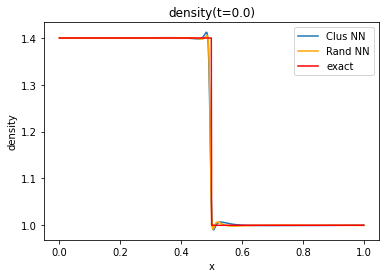

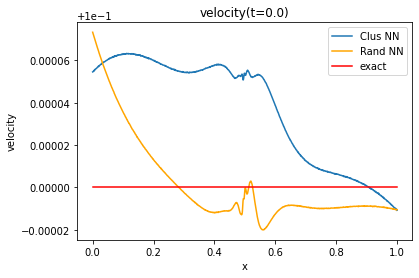

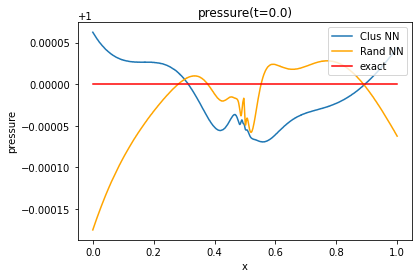

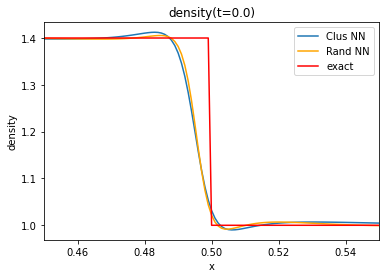

In [51]:
fig1,ax1 = plt.subplots(1)
ax1.set_title(f"density(t={tmin})")
ax1.set_xlabel('x')
ax1.set_ylabel('density')
ax1.plot(x[:,0],density_clus[0],label="Clus NN")
ax1.plot(x[:,0],density_rand[0],color="orange",label="Rand NN",markersize=3)
yy = np.array([1.4 if tmp<0.5+0.1*tmin else 1.0 for tmp in x[:,0]])
ax1.plot(x[:,0],yy,color="r",label='exact')
ax1.legend(loc="upper right")

fig2,ax2 = plt.subplots(1)
ax2.set_title(f"velocity(t={tmin})")
ax2.set_xlabel('x')
ax2.set_ylabel('velocity')
ax2.plot(x[:,0],velocity_clus[0],label="Clus NN")
ax2.plot(x[:,0],velocity_rand[0],color="orange",label="Rand NN",markersize=3)
ax2.plot(x[:,0],np.ones(len(x[:,0]))*0.1,color="r",label="exact")
ax2.legend(loc="upper right")

fig3,ax3 = plt.subplots(1)
ax3.set_title(f"pressure(t={tmin})")
ax3.set_xlabel('x')
ax3.set_ylabel('pressure')
ax3.plot(x[:,0],pressure_clus[0],label="Clus NN")
ax3.plot(x[:,0],pressure_rand[0],color="orange",label="Rand NN",markersize=3)
ax3.plot(x[:,0],np.ones(len(x[:,0])),color="r",label="exact")
ax3.legend(loc="upper right")

fig4,ax4 = plt.subplots(1)
ax4.set_title(f"density(t={tmin})")
ax4.set_xlabel('x')
ax4.set_ylabel('density')
ax4.plot(x[:,0],density_clus[0],label="Clus NN")
ax4.plot(x[:,0],density_rand[0],color="orange",label="Rand NN",markersize=3)
yy = np.array([1.4 if tmp<0.5+0.1*tmin else 1.0 for tmp in x[:,0]])
ax4.plot(x[:,0],yy,color="r",label='exact')
ax4.legend(loc="upper right")
ax4.set_xlim(0.45,0.55)